## ReAct Agent with Tools

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

In [2]:
## Load LLM model
model = 'deepseek-r1-distill-llama-70b'
llm = ChatGroq(model=model)

In [3]:
## Test model
llm.invoke('Hi').content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

### 

In [2]:
import operator
from typing import List, TypedDict, Annotated, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

In [5]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm.invoke(question)
    return {'messages':[response]}

In [6]:
def call_model2(state: MessagesState):
    message = state['messages']
    print(message)
    question = HumanMessage(message)
    response = llm.invoke(question)
    return {'messages':[response]}

In [7]:
state = {'messages':['Hi how are you']}
call_model({'messages':['Hi how are you']})

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 7, 'total_tokens': 49, 'completion_time': 0.205987285, 'prompt_time': 0.000349954, 'queue_time': 0.21818555399999998, 'total_time': 0.206337239}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--c56986de-26b0-498c-b605-86c18cf26c33-0', usage_metadata={'input_tokens': 7, 'output_tokens': 42, 'total_tokens': 49})]}

In [1]:
## create a workflow
workflow = StateGraph(MessagesState)
## add node
workflow.add_node('Chatbot', call_model)
## add edges
workflow.add_edge(START,'Chatbot')
workflow.add_edge('Chatbot',END)
## complie the workflow
app = workflow.compile()
app

NameError: name 'StateGraph' is not defined

## Custom Tool

In [9]:
from langchain.tools import tool
@tool
def search(query:str):
    '''this is a custom tool for searching weather'''
    if 'delhi' in query.lower():
        return 'the temperature is 40 degree and sunny'
    return "the temo is 25 degree and cloudy"

search.invoke('what is the temperature in delhi')

'the temperature is 40 degree and sunny'

In [10]:
search.invoke('what is the temperature in Kerala')

'the temo is 25 degree and cloudy'

In [11]:
llm_with_tool = llm.bind_tools([search])

In [12]:
response = llm_with_tool.invoke('what is the weather in delhi')
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'knnfznsz8', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 126, 'prompt_tokens': 131, 'total_tokens': 257, 'completion_time': 0.469692053, 'prompt_time': 0.00903724, 'queue_time': 0.227033214, 'total_time': 0.478729293}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--10c61b64-adba-4b77-8ae7-d81dae5dd60c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'knnfznsz8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 126, 'total_tokens': 257})

In [13]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'knnfznsz8',
  'type': 'tool_call'}]

In [14]:
## Method with LLM bind tool
def call_model(state:MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {'messages':[response]}

In [15]:
response = call_model({'messages':['what is the weather in delhi']})
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ywphz5x58', 'function': {'arguments': '{"query":"what is the weather in delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 225, 'prompt_tokens': 131, 'total_tokens': 356, 'completion_time': 1.01377134, 'prompt_time': 0.008496899, 'queue_time': 0.226993817, 'total_time': 1.022268239}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--30f45346-1772-4e7d-a046-ad0052198da1-0', tool_calls=[{'name': 'search', 'args': {'query': 'what is the weather in delhi'}, 'id': 'ywphz5x58', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 225, 'total_tokens': 356})]}

In [ ]:
## tool router function
def tool_router(state:MessagesState):
    last_message = state['messages'][-1]
    #print(f'Last Message: {last_message}')
    
    if last_message.tool_calls:
        return 'tools'
    return END

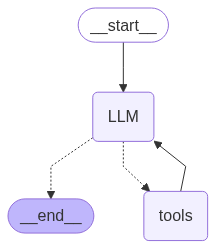

In [17]:
## Workflow
workflow_tool = StateGraph(MessagesState)
workflow_tool.add_node('LLM',call_model)
workflow_tool.add_node('tools', ToolNode([search]))
workflow_tool.add_edge(START,'LLM')
workflow_tool.add_conditional_edges(
    'LLM',
    tool_router,
    {
        'tools':'tools',
        END:END
    }
)
workflow_tool.add_edge('tools','LLM')
tool_app = workflow_tool.compile()
tool_app

In [18]:
## Stream graph steps for single input

for output in tool_app.stream({'messages':'what is the temperature in Delhi'}):
    for key,value in output.items():
        print(f'Output : {key}')
        print("-"*20)
        print(f'Value: {value}\n')

Output : LLM
--------------------
Value: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gzz57g0fc', 'function': {'arguments': '{"query":"temperature in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 130, 'total_tokens': 227, 'completion_time': 0.447841487, 'prompt_time': 0.008595157, 'queue_time': 0.220533328, 'total_time': 0.456436644}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7fab60ca-2514-416f-9060-977e62e0e543-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in Delhi'}, 'id': 'gzz57g0fc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 97, 'total_tokens': 227})]}

Output : tools
--------------------
Value: {'messages': [ToolMessage(content='the temperature is 40 degree and sunny', name='search', id='8668b055-6c00-4290-86d9-

### Memory in Agent


A checkpoint saver object or flag. If provided, this Checkpointer serves as a fully versioned "short-term memory" for the graph, allowing it to be paused, resumed, and replayed from any point. If None, it may inherit the parent graph's checkpointer when used as a subgraph. If False, it will not use or inherit any checkpointer.

In [19]:
from langgraph.checkpoint.memory import MemorySaver

In [20]:
## obejct of memory saver
memory = MemorySaver()

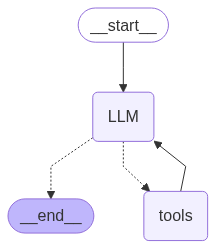

In [21]:
## Workflow
workflow_tool2 = StateGraph(MessagesState)
workflow_tool2.add_node('LLM',call_model)
workflow_tool2.add_node('tools', ToolNode([search]))
workflow_tool2.add_edge(START,'LLM')
workflow_tool2.add_conditional_edges(
    'LLM',
    tool_router,
    {
        'tools':'tools',
        END:END
    }
)
workflow_tool2.add_edge('tools','LLM')
tool_app2 = workflow_tool2.compile(checkpointer=memory)
tool_app2

In [22]:
config = {'configurable':{'thread_id':'1'}}

In [24]:
events = tool_app2.stream({'messages':['temperature in Delhi']},config=config, stream_mode='values')

for event in events:
    print(event['messages'][-1].pretty_print())

================================ Human Message =================================

temperature in Delhi
None
================================== Ai Message ==================================

The temperature in Delhi is 40 degrees and sunny.
None


In [25]:
memory.get(config=config)

{'v': 3,
 'ts': '2025-06-14T05:46:18.968655+00:00',
 'id': '1f048e2e-4f6f-6f1d-801b-775ee4696d05',
 'channel_versions': {'__start__': '00000000000000000000000000000028.0.13277970997181887',
  'messages': '00000000000000000000000000000029.0.9216681454383607',
  'branch:to:LLM': '00000000000000000000000000000029.0.1770711784013249',
  'branch:to:tools': '00000000000000000000000000000026.0.049733733969906324'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000027.0.9057643850773982'},
  'LLM': {'branch:to:LLM': '00000000000000000000000000000028.0.054319956979763995'},
  'tools': {'branch:to:tools': '00000000000000000000000000000025.0.11186111176680347'}},
 'channel_values': {'messages': [HumanMessage(content='what is the temperature in Delhi', additional_kwargs={}, response_metadata={}, id='2a0756ab-aea1-495c-9a33-6b3f75b91bf1'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2a278pq7s', 'function': {'arguments': '{"query":